This module is using Logistic Regression from Scikit Learn for classification. Earlier, I had added Logistic Regression using Neural Networks yielding an accuracy of about 80%. Using GridSearchCV for finding the right hyperparameters, the accuracy from the model has increased to about 93%.
Thus, setting up the right hyperparameters is important in machine learning.

The process can be replicated for other models and is as follows:
1. Importing the right libraries and classifier
2. Loading data from UCI website (open-source)
3. Defining functions to plot Confusion matrix
4. Nested cross-validation is used to compare different models (here not so useful)
5. Predicting using the best hyperparameters
6. Plotting confusion matrix, ROC, AUC and Lift charts

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
import scikitplot as skplt
from sklearn.pipeline import Pipeline
import itertools

### Data Loading

In [2]:
spam = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header = None)
X = spam.loc[:,0:56]
y = spam.loc[:,57]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

### Defining required functions 

In [3]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def nested_cross_validation(model_name, parameters, X_train, y_train, scaler = None):
    NUM_TRIALS = 10
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)

    for i in range(NUM_TRIALS):
        pipeline = Pipeline([('transformer', scaler), ('estimator', model_name)])

        inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

        #clf = GridSearchCV(estimator = model_name, param_grid = parameters, cv=inner_cv)
        clf = GridSearchCV(pipeline, param_grid = parameters, cv=inner_cv)
        clf.fit(X_train, y_train)
        
        pipeline2 = Pipeline([('transformer', scaler), ('estimator', clf)])

        # Nested CV with parameter optimization
        nested_score = cross_val_score(pipeline2, X=X_train, y=y_train, cv=outer_cv)
        nested_scores[i] = nested_score.mean()

    print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), \
                                                                                        nested_scores.std()))
    #print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


    accuracy_all_models.append(nested_scores.mean())
    std_all_models.append(nested_scores.std())

In [5]:
def feature_selection_func(estimator, params, X_train, y_train, scaler = None):
    sfs1 = sfs(estimator, k_features='best', forward=True, floating=False, cv=10, scoring = 'accuracy')

    sfs2 = sfs1.fit(X_train, y_train)
    fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()
    print('Selected features:', sfs2.k_feature_idx_)
    X_train_sfs = sfs2.transform(X_train)
    X_test_sfs = sfs2.transform(X_test)
    nested_cross_validation(estimator, params, X_train_sfs, y_train, scaler)

In [6]:
accuracy_all_models = []
cross_val_score_all_models = []
precision_all = []
recall_all = []
f_measure_all = []
std_all_models = [] 

### Logistic Regression (using Scikit-Learn) 

In [7]:
clf = LogisticRegression()
param = {"estimator__C": [0.1, 1, 10, 100], "estimator__penalty" : ['l1','l2']}
nested_cross_validation(clf, param, X_train, y_train)

The final accuracy from nested cross validation is 92.32% / 0.21%


In [8]:
param = {"C": [0.1, 1, 10, 100], "penalty" : ['l1','l2']}

lr = GridSearchCV(LogisticRegression(), param, cv = 10, scoring = 'accuracy')
lr.fit(X_train,y_train)
model = lr.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Prediction Accuracy: {0:.2%}\n".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Prediction Accuracy: 92.73%

             precision    recall  f1-score   support

          0       0.93      0.96      0.94       558
          1       0.93      0.88      0.91       363

avg / total       0.93      0.93      0.93       921



Normalized confusion matrix


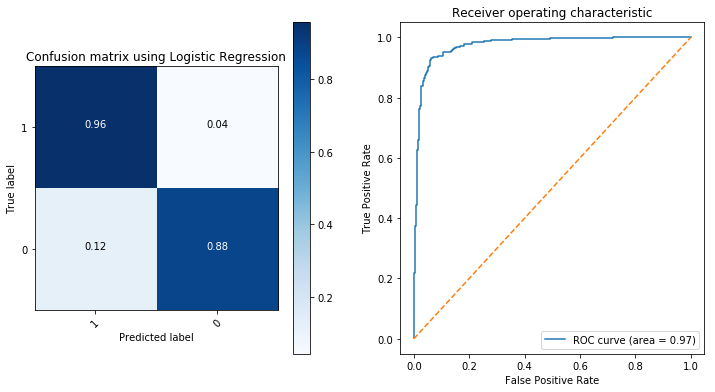

In [9]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(y.unique())

plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using Logistic Regression')

## Predict scores
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#Plot ROC 
# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

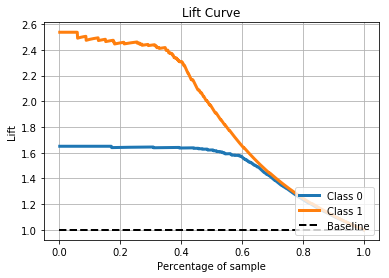

In [10]:
skplt.metrics.plot_lift_curve(y_test,model.predict_proba(X_test))
plt.show()